In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score


plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore")


In [2]:
yelp_business = pd.read_csv('data/yelp_business.csv')

In [3]:
yelp_business.head()

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",NaN,"""6025 N 27th Ave, Ste 1""",Phoenix,AZ,85017,33.524903,-112.115310,1.5,18,1,Departments of Motor Vehicles;Public Services ...
3,8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",NaN,"""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,0,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...


Now let's check for the missing values

There are many missing values in neighborhood and postal code fields.

**1.2 Missing values in our dataset:**

In [4]:
yelp_business.isnull().sum()

business_id          0
name                 0
neighborhood    106552
address              0
city                 1
state                1
postal_code        623
latitude             1
longitude            1
stars                0
review_count         0
is_open              0
categories           0
dtype: int64

The following heatmap can be used to visualize the missing values effectively

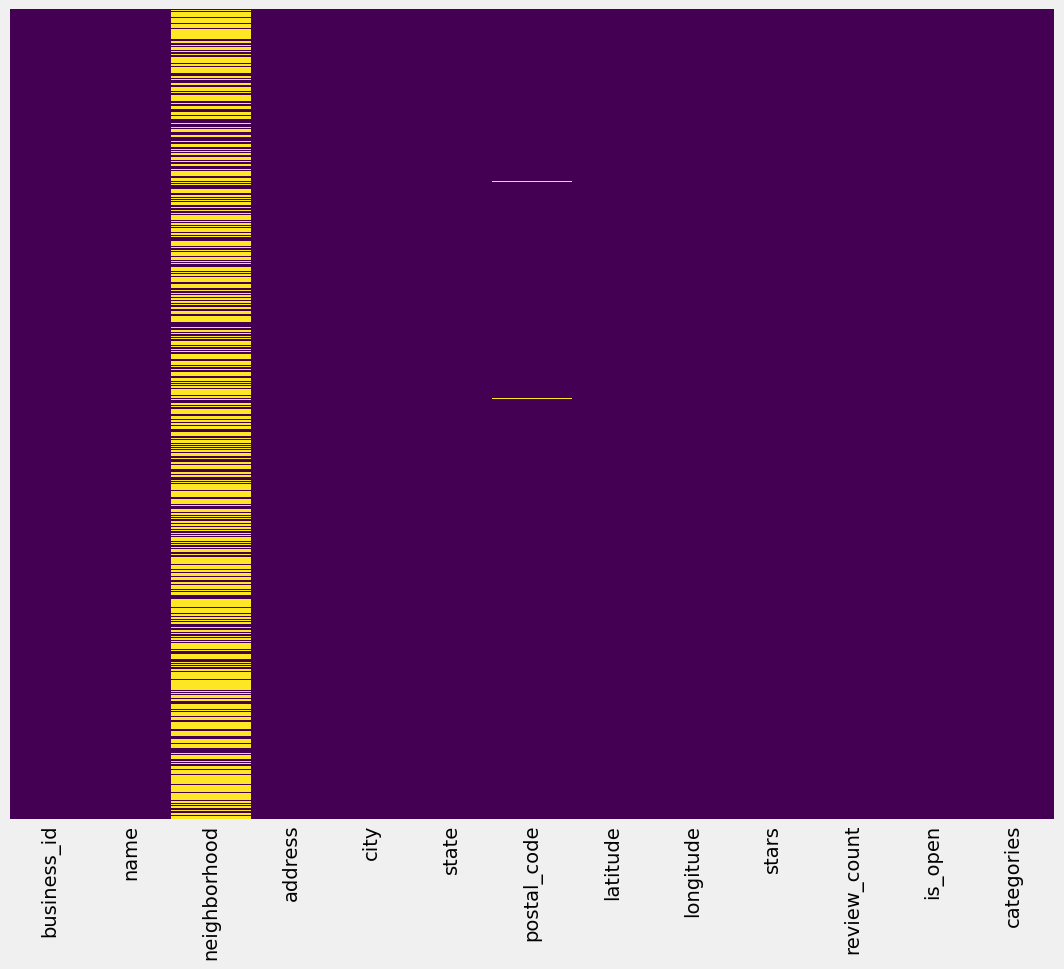

In [5]:
plt.figure(figsize=(12,10))
f = sns.heatmap(yelp_business.isnull(),yticklabels=False, cbar=False, cmap = 'viridis')

let's check how many of the businesses are open using a count plot on seaborn

**1.3 Distribution of variables**

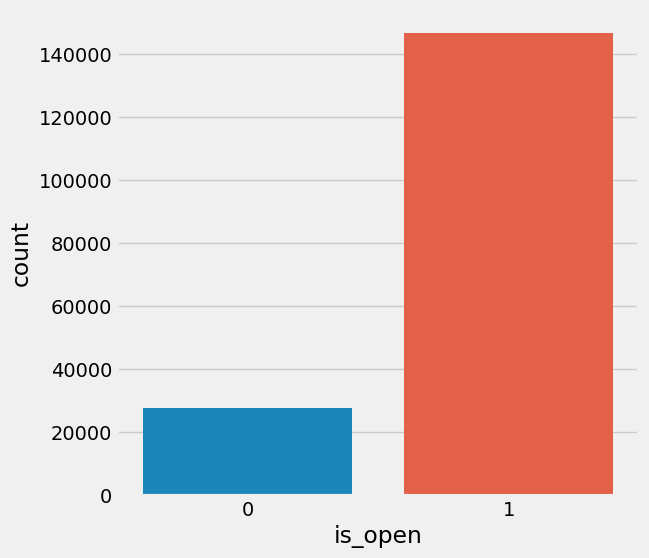

In [6]:
plt.figure(figsize=(6,6))
sns.countplot(x='is_open',data=yelp_business);

In [7]:
#let's look at the number of unique values in the stars variable.

yelp_business['stars'].nunique()

9

let's use a plot to visualize the frequency of the ratings

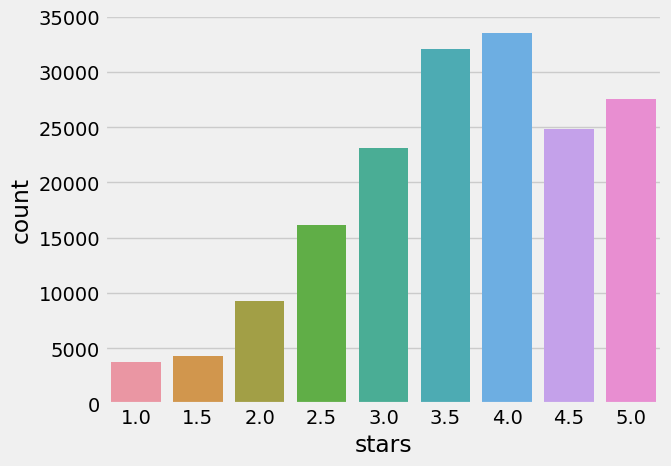

In [8]:
sns.countplot(x='stars',data=yelp_business);

We see that most of the businesses got a rating of either 3 or above

Let's visualize the distribution of number of reviews that a business has, we have applied log since the distribution is extremely skewed

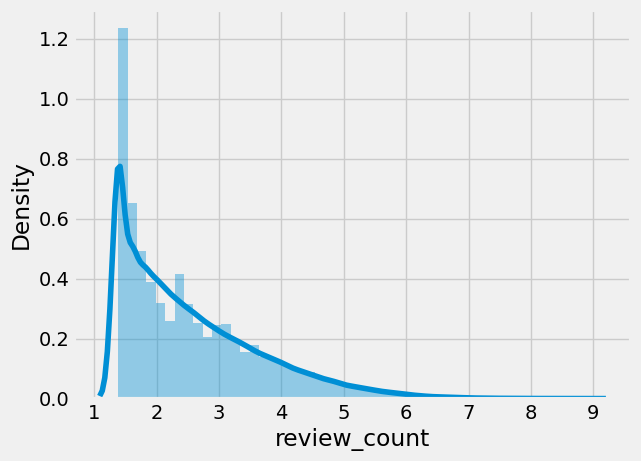

In [9]:
sns.distplot(yelp_business['review_count'].apply(np.log1p));

In [10]:
yelp_business_attributes = pd.read_csv('data/yelp_business_attributes.csv')

Our intuition is that the number of businesses vary a lot from one state to another.

We can use a tree map to visualize some of them since  a tree map might not be able to fit all the states

In [11]:

by_state = yelp_business.groupby('state')

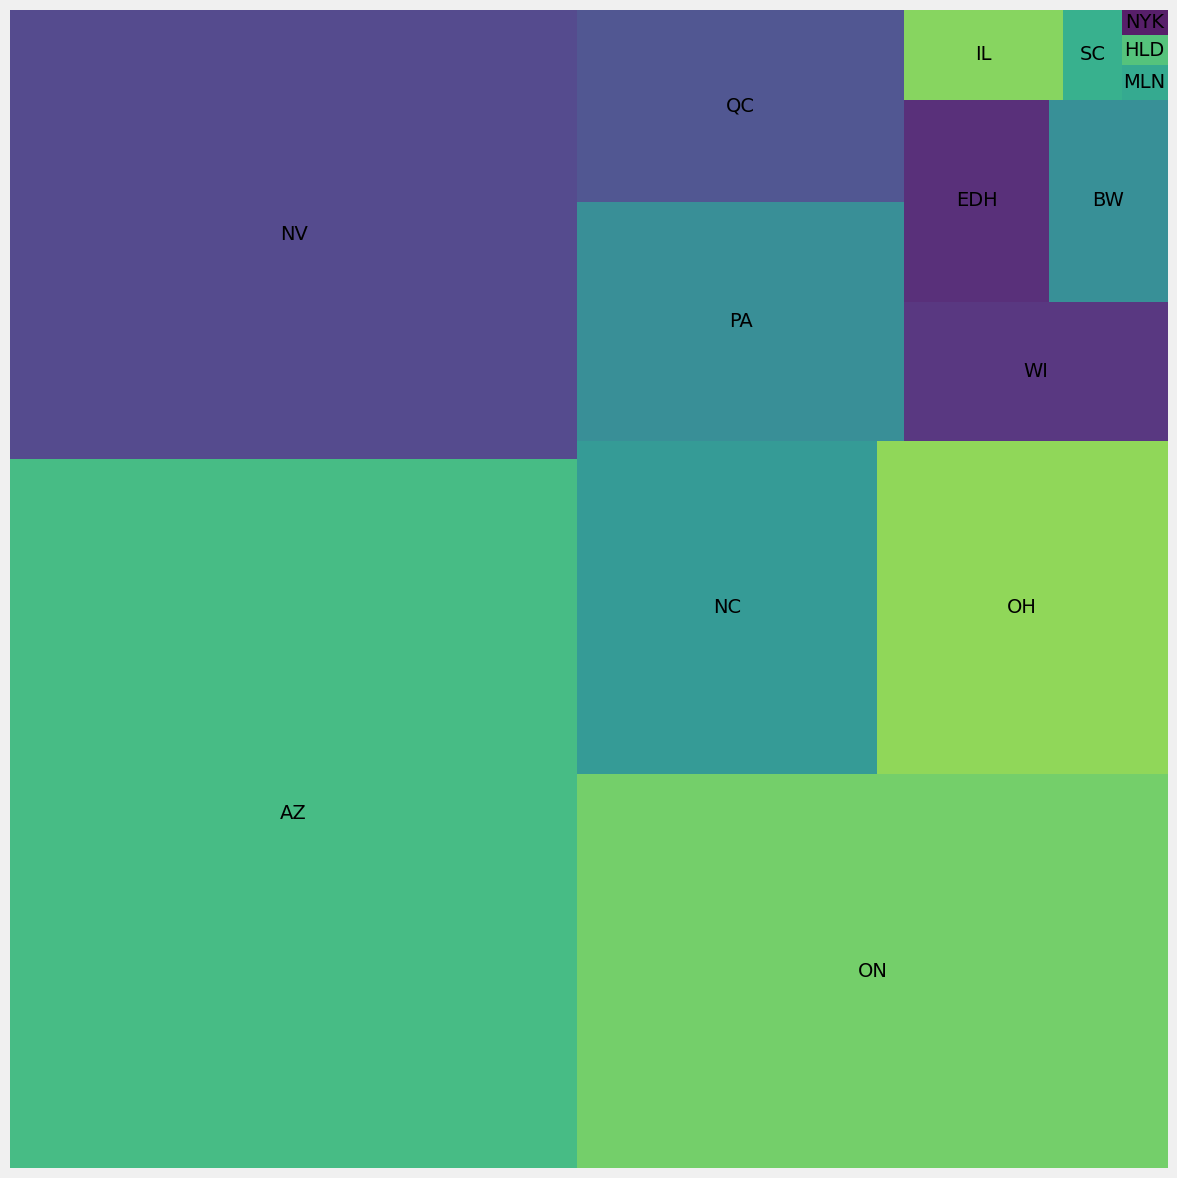

In [12]:
import squarify    # pip install squarify (algorithm for treemap)
plt.figure(figsize=(12,12))

a = by_state['business_id'].count()

a.sort_values(ascending=False,inplace=True)

squarify.plot(sizes= a[0:15].values, label= a[0:15].index, alpha=0.9)

plt.axis('off')
plt.tight_layout()

From the tree chat, we see that Arizona and Nevada has the most number of businesses

**1.4 Leading Business Categories:**

Let's look at the leading business categories in out dataset. 
A business is linked to multiple categories in our dataset, so we have to do a bit of preprocessing.


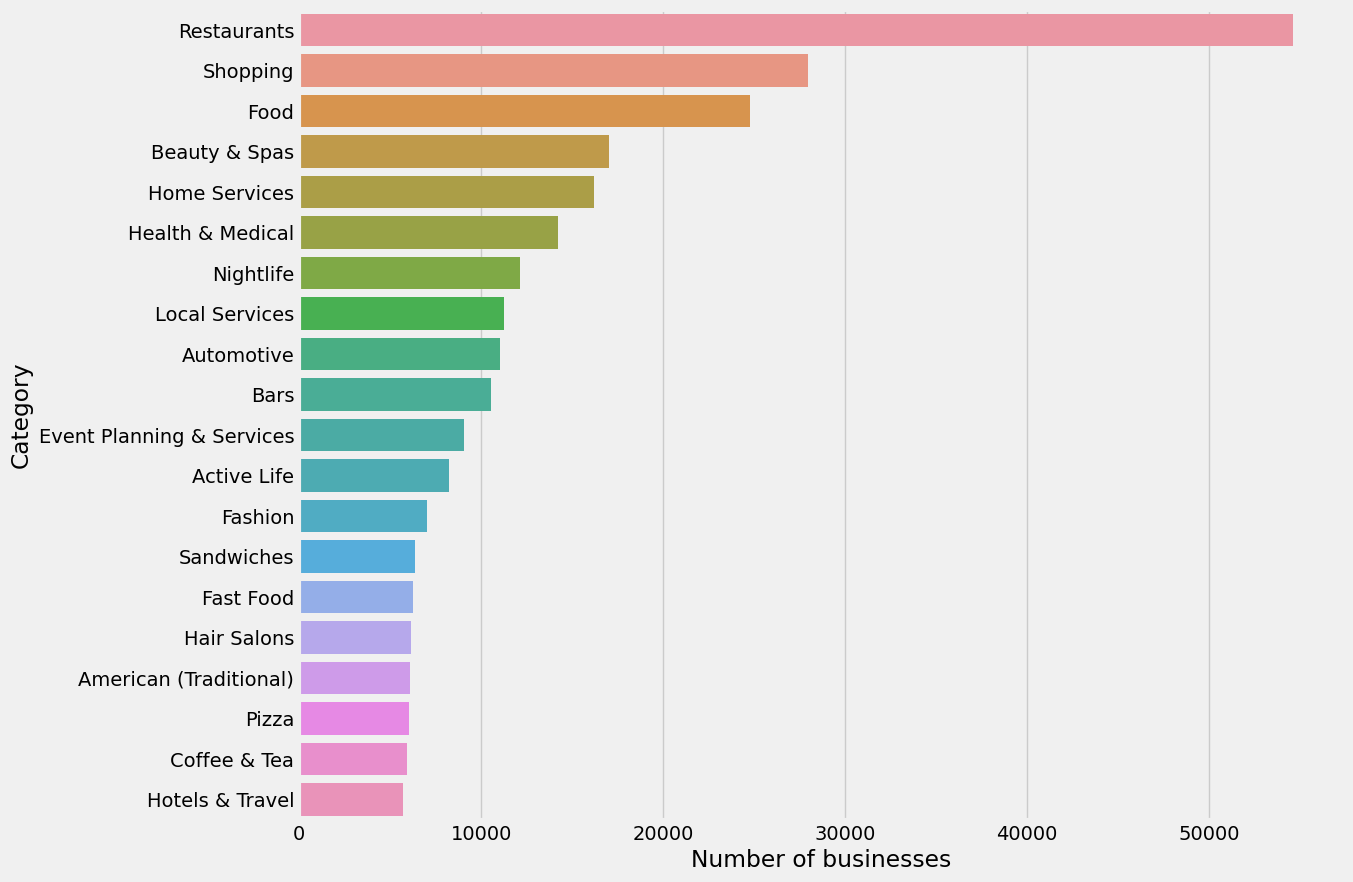

In [13]:


business_cats=';'.join(yelp_business['categories'])
cats=pd.DataFrame(business_cats.split(';'),columns=['category'])
cats_ser = cats.category.value_counts()


cats_df = pd.DataFrame(cats_ser)
cats_df.reset_index(inplace=True)

plt.figure(figsize=(12,10))
f = sns.barplot( y= 'index',x = 'category' , data = cats_df.iloc[0:20])
f.set_ylabel('Category')
f.set_xlabel('Number of businesses');

**1.5 Top Business Names:**

The top business names in our dataset can be visualized with a word cloud.

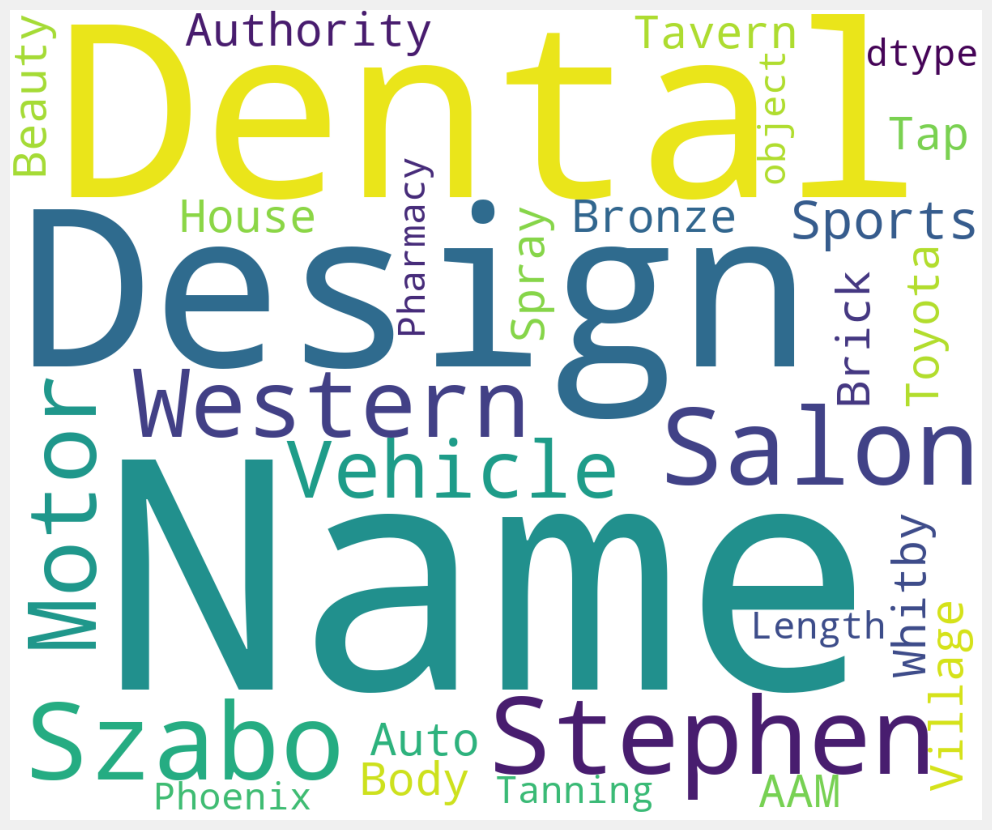

In [14]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))

wordcloud = WordCloud(background_color='white',
                          width=1200,
                      stopwords = STOPWORDS,
                          height=1000
                         ).generate(str(yelp_business['name']))


plt.imshow(wordcloud)
plt.axis('off');

cols1 is a list of our explanatory variables we want to use in our models.
The dependent variable we are trying to predict is whether a business is open.

In [15]:
cols1 = ['latitude',
 'longitude',
 'stars',
 'review_count']

In [16]:
X = yelp_business[cols1]
y = yelp_business['is_open']

In [17]:
X.fillna(0.0,inplace=True)

In [18]:
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = 0.3, random_state = 42)

We are going to smote just the training data because creating synthetic observations using the test dataset violates the rules of cross validation.

In [19]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(train_X, train_y)

In [20]:
X_res = pd.DataFrame(X_res)
y_res = pd.DataFrame(y_res)
test_X = pd.DataFrame(test_X)
test_y = pd.DataFrame(test_y)

In [21]:
L = [0.0001,0.001,0.01,0.1,1,10]
accuracy = {}
for i in L:
    LR = LogisticRegression(C=i)
    LR.fit(X_res,y_res)
    pred_y = LR.predict(test_X)
    
    accuracy[i] = 100*accuracy_score(test_y,pred_y)

In [22]:
accuracy

{0.0001: 54.23612304519677,
 0.001: 55.70258349086327,
 0.01: 55.93553684290924,
 0.1: 55.96035974107808,
 1: 55.962269194783374,
 10: 55.962269194783374}

''

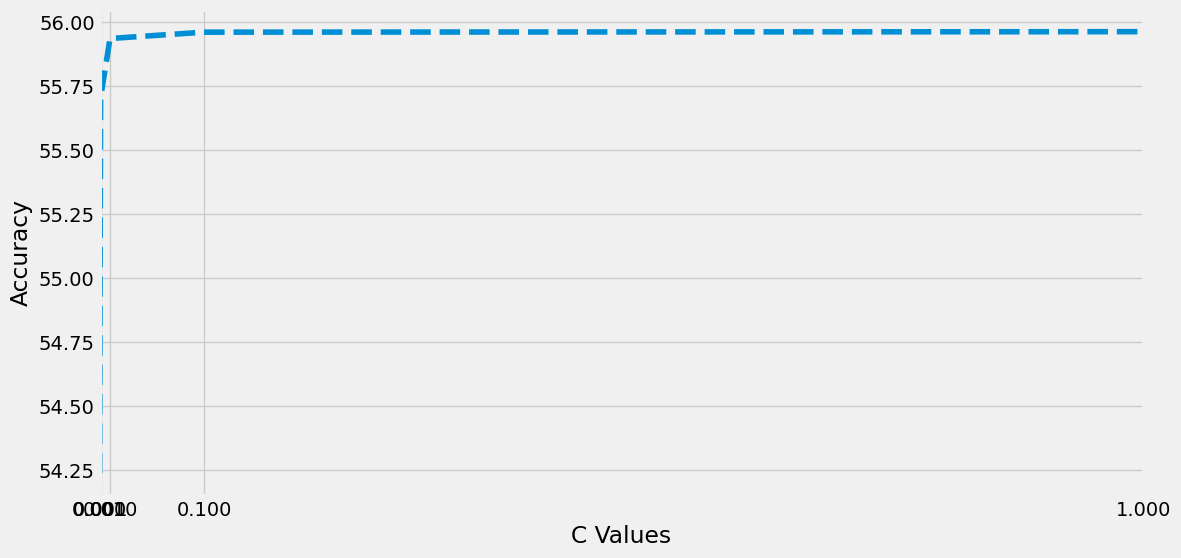

In [23]:
plt.figure(figsize=(12,6))
plt.plot( list(accuracy.keys()), list(accuracy.values()), '--')
plt.xticks(list(accuracy.keys()))
plt.xlim(0,1)
plt.xlabel("C Values")
plt.ylabel("Accuracy")
;

Based on the above visualization, I have chosen a C value of 0.001
A lower C value means more regularization

In [24]:
LR = LogisticRegression(C=0.001)
LR.fit(X_res,y_res)
pred_y = LR.predict(test_X)

In [25]:
confusion_matrix(test_y,pred_y)

array([[ 4554,  3864],
       [19335, 24618]])

In [26]:
from sklearn.metrics import accuracy_score

accuracy_score(test_y,pred_y)

0.5570258349086327

In [27]:
review = pd.read_csv('data/yelp_review.csv')
#checkin = pd.read_csv('../input/yelp_checkin.csv')

review_busines = review.groupby(by='business_id')

review_businesid = pd.DataFrame()
review_businesid['Mean'] = review_busines['stars'].mean()
review_businesid['Median'] = review_busines['stars'].median()
review_businesid['NumberOfReviews'] = review_busines['stars'].count()

In [28]:
checkin = pd.read_csv("data/yelp_checkin.csv")

checkin_bus = checkin.groupby(by='business_id')

checkin_busid = pd.DataFrame()
checkin_busid['TotalCheckins'] = checkin_bus['checkins'].sum()

checkin_busid.reset_index(inplace=True)
review_businesid.reset_index(inplace=True)


review_businesid = pd.merge(left=review_businesid,right=checkin_busid,on='business_id', how='left')

The last step is merging this data frame to our original dataframe yelp_business

In [29]:
yelp_business = pd.merge(left=yelp_business,right=review_businesid,on='business_id',how='left')

In [30]:
yelp_business.columns

Index(['business_id', 'name', 'neighborhood', 'address', 'city', 'state',
       'postal_code', 'latitude', 'longitude', 'stars', 'review_count',
       'is_open', 'categories', 'Mean', 'Median', 'NumberOfReviews',
       'TotalCheckins'],
      dtype='object')

In [31]:
cols1 = ['stars',
 'review_count',
        'Mean', 'Median', 'NumberOfReviews','TotalCheckins']

In [32]:
X = yelp_business[cols1]
y = yelp_business['is_open']

X.fillna(0.0,inplace=True)

Train test split again

In [33]:
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = 0.3, random_state = 42)

SMOTE

In [35]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(train_X, train_y)

In [36]:
X_res = pd.DataFrame(X_res,columns = train_X.columns.tolist())
y_res = pd.DataFrame(y_res)
test_X = pd.DataFrame(test_X)
test_y = pd.DataFrame(test_y)

In [37]:
L = [0.0001,0.001,0.01,0.1,1,10]

accuracy = {}
for i in L:
    LR = LogisticRegression(C=i)
    LR.fit(X_res,y_res)
    pred_y = LR.predict(test_X)
    
    accuracy[i] = 100*accuracy_score(test_y,pred_y)

In [38]:
accuracy

{0.0001: 54.61610433255045,
 0.001: 51.82448301540929,
 0.01: 51.70418743197571,
 0.1: 51.61062420041627,
 1: 51.614443107826844,
 10: 51.61253365412155}

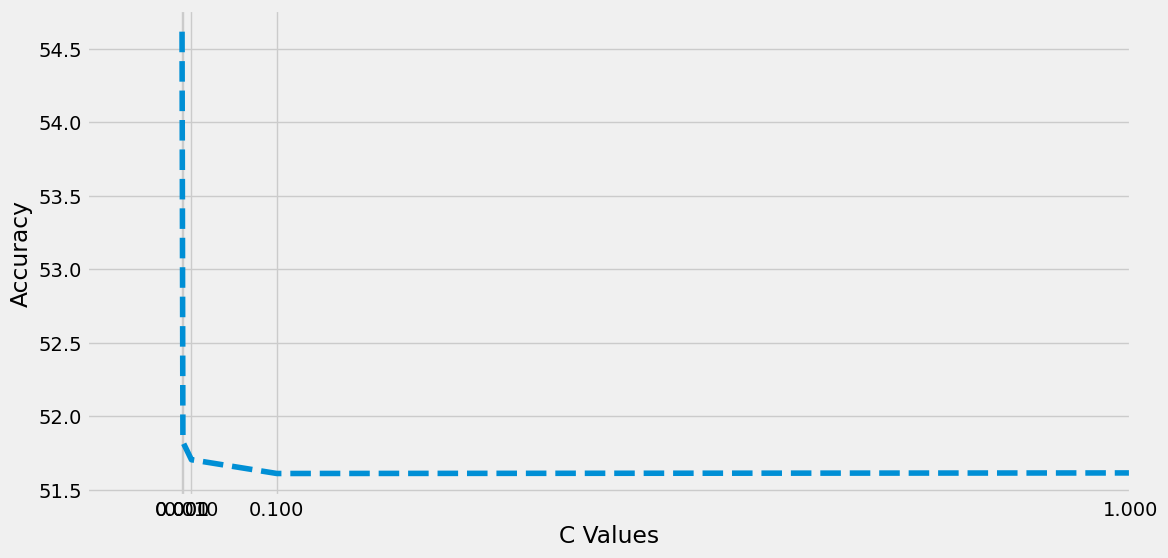

In [39]:
plt.figure(figsize=(12,6))
plt.plot( list(accuracy.keys()), list(accuracy.values()), '--')
plt.xticks(list(accuracy.keys()))
plt.xlim(-0.1,1)
plt.xlabel("C Values")
plt.ylabel("Accuracy");

We chose a C value of 0.0001 based on the above plot.

In [40]:
LR = LogisticRegression(C=0.0001)
LR.fit(X_res,y_res)
pred_y = LR.predict(test_X)

In [41]:
accuracy_score(test_y,pred_y)

0.5461610433255045

In [42]:
confusion_matrix(test_y,pred_y)

array([[ 4554,  3864],
       [19904, 24049]])

The accuracy improved by more than 2% to 58.5%,  But this isn't good enough.



Let's try an XGBoost model on this dataset and see how it performs.

In [43]:
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=2017, num_rounds=400):
    param = {}
    param['objective'] = 'multi:softmax'
    param['num_class'] = 2
    param['eta'] = 0.12
    param['max_depth'] = 5
    param['silent'] = 1
    param['eval_metric'] = 'merror'
    param['min_child_weight'] = 1
    param['subsample'] = 0.5
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest)
    return model,pred_test_y

In [44]:
test_y_pred= pd.DataFrame()
test_y_pred['id'] = test_y.index
test_y_pred['is_open'] = np.zeros_like(test_y.index)

In [45]:
X_res = X_res.values
y_res = y_res.values
test_X = test_X.values

In [48]:
kfold = 5
skf = StratifiedKFold(n_splits=kfold, random_state=42, shuffle = True)

for i, (train_index, test_index) in enumerate(skf.split(X_res, y_res)):
    print('[Fold %d/%d]' % (i + 1, kfold))
    X_train, X_valid = X_res[train_index], X_res[test_index]
    y_train, y_valid = y_res[train_index], y_res[test_index]
    
    model1,y = runXGB( X_train,y_train,X_valid,y_valid)
    test_pred = model1.predict(xgb.DMatrix(test_X))
    test_y_pred['is_open'] += test_pred/kfold

[Fold 1/5]
[16:55:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-merror:0.33573	test-merror:0.34029
[1]	train-merror:0.33416	test-merror:0.33703
[2]	train-merror:0.32305	test-merror:0.32776
[3]	train-merror:0.32297	test-merror:0.32793
[4]	train-merror:0.32242	test-merror:0.32672
[5]	train-merror:0.32022	test-merror:0.32377
[6]	train-merror:0.31612	test-merror:0.31956
[7]	train-merror:0.31053	test-merror:0.31521
[8]	train-merror:0.30654	test-merror:0.31158
[9]	train-merror:0.30686	test-merror:0.31178
[10]	train-merror:0.30842	test-merror:0.31297
[11]	train-merror:0.30541	test-merror:0.31041
[12]	train-merror:0.30408	test-merror:0.30998
[13]	train-merror:0.29698	test-merror:0.30280
[14]	train-merror:0.29550	test-merror:0.30165
[15]	train-merror:0.29512	test-merror:0.30156
[16]	train-merror:0.29354	test-merror:0.30007
[17]	train-merror:0.29037	test-merror:

[173]	train-merror:0.23339	test-merror:0.24404
[174]	train-merror:0.23334	test-merror:0.24397
[175]	train-merror:0.23325	test-merror:0.24367
[176]	train-merror:0.23284	test-merror:0.24316
[177]	train-merror:0.23274	test-merror:0.24333
[178]	train-merror:0.23269	test-merror:0.24336
[179]	train-merror:0.23270	test-merror:0.24333
[180]	train-merror:0.23278	test-merror:0.24353
[181]	train-merror:0.23259	test-merror:0.24336
[182]	train-merror:0.23245	test-merror:0.24309
[183]	train-merror:0.23231	test-merror:0.24302
[184]	train-merror:0.23250	test-merror:0.24333
[185]	train-merror:0.23226	test-merror:0.24316
[186]	train-merror:0.23213	test-merror:0.24302
[187]	train-merror:0.23193	test-merror:0.24270
[188]	train-merror:0.23188	test-merror:0.24285
[189]	train-merror:0.23186	test-merror:0.24282
[190]	train-merror:0.23182	test-merror:0.24253
[191]	train-merror:0.23174	test-merror:0.24238
[192]	train-merror:0.23146	test-merror:0.24224
[193]	train-merror:0.23133	test-merror:0.24219
[194]	train-m

[348]	train-merror:0.21846	test-merror:0.23129
[349]	train-merror:0.21832	test-merror:0.23109
[350]	train-merror:0.21833	test-merror:0.23107
[351]	train-merror:0.21832	test-merror:0.23090
[352]	train-merror:0.21829	test-merror:0.23088
[353]	train-merror:0.21808	test-merror:0.23073
[354]	train-merror:0.21802	test-merror:0.23073
[355]	train-merror:0.21801	test-merror:0.23071
[356]	train-merror:0.21795	test-merror:0.23066
[357]	train-merror:0.21788	test-merror:0.23066
[358]	train-merror:0.21794	test-merror:0.23056
[359]	train-merror:0.21779	test-merror:0.23049
[360]	train-merror:0.21775	test-merror:0.23058
[361]	train-merror:0.21773	test-merror:0.23051
[362]	train-merror:0.21758	test-merror:0.23017
[363]	train-merror:0.21750	test-merror:0.23012
[364]	train-merror:0.21746	test-merror:0.23005
[365]	train-merror:0.21742	test-merror:0.22988
[366]	train-merror:0.21713	test-merror:0.22988
[367]	train-merror:0.21704	test-merror:0.22985
[368]	train-merror:0.21709	test-merror:0.22981
[369]	train-m

[121]	train-merror:0.24309	test-merror:0.24377
[122]	train-merror:0.24293	test-merror:0.24360
[123]	train-merror:0.24275	test-merror:0.24358
[124]	train-merror:0.24273	test-merror:0.24360
[125]	train-merror:0.24257	test-merror:0.24363
[126]	train-merror:0.24252	test-merror:0.24336
[127]	train-merror:0.24231	test-merror:0.24319
[128]	train-merror:0.24214	test-merror:0.24304
[129]	train-merror:0.24203	test-merror:0.24311
[130]	train-merror:0.24171	test-merror:0.24309
[131]	train-merror:0.24124	test-merror:0.24270
[132]	train-merror:0.24103	test-merror:0.24221
[133]	train-merror:0.24098	test-merror:0.24226
[134]	train-merror:0.24043	test-merror:0.24173
[135]	train-merror:0.24023	test-merror:0.24161
[136]	train-merror:0.24003	test-merror:0.24141
[137]	train-merror:0.23949	test-merror:0.24107
[138]	train-merror:0.23945	test-merror:0.24071
[139]	train-merror:0.23935	test-merror:0.24097
[140]	train-merror:0.23925	test-merror:0.24075
[141]	train-merror:0.23894	test-merror:0.24049
[142]	train-m

[296]	train-merror:0.22389	test-merror:0.22715
[297]	train-merror:0.22381	test-merror:0.22710
[298]	train-merror:0.22373	test-merror:0.22706
[299]	train-merror:0.22360	test-merror:0.22701
[300]	train-merror:0.22360	test-merror:0.22701
[301]	train-merror:0.22342	test-merror:0.22693
[302]	train-merror:0.22323	test-merror:0.22693
[303]	train-merror:0.22322	test-merror:0.22684
[304]	train-merror:0.22318	test-merror:0.22679
[305]	train-merror:0.22304	test-merror:0.22667
[306]	train-merror:0.22308	test-merror:0.22657
[307]	train-merror:0.22315	test-merror:0.22642
[308]	train-merror:0.22316	test-merror:0.22650
[309]	train-merror:0.22304	test-merror:0.22645
[310]	train-merror:0.22293	test-merror:0.22628
[311]	train-merror:0.22295	test-merror:0.22630
[312]	train-merror:0.22279	test-merror:0.22623
[313]	train-merror:0.22275	test-merror:0.22625
[314]	train-merror:0.22324	test-merror:0.22637
[315]	train-merror:0.22316	test-merror:0.22628
[316]	train-merror:0.22312	test-merror:0.22625
[317]	train-m

[68]	train-merror:0.25603	test-merror:0.25353
[69]	train-merror:0.25575	test-merror:0.25297
[70]	train-merror:0.25573	test-merror:0.25297
[71]	train-merror:0.25517	test-merror:0.25287
[72]	train-merror:0.25488	test-merror:0.25319
[73]	train-merror:0.25455	test-merror:0.25285
[74]	train-merror:0.25450	test-merror:0.25297
[75]	train-merror:0.25379	test-merror:0.25204
[76]	train-merror:0.25346	test-merror:0.25175
[77]	train-merror:0.25352	test-merror:0.25187
[78]	train-merror:0.25338	test-merror:0.25161
[79]	train-merror:0.25323	test-merror:0.25158
[80]	train-merror:0.25284	test-merror:0.25141
[81]	train-merror:0.25292	test-merror:0.25148
[82]	train-merror:0.25280	test-merror:0.25158
[83]	train-merror:0.25240	test-merror:0.25122
[84]	train-merror:0.25227	test-merror:0.25085
[85]	train-merror:0.25130	test-merror:0.24966
[86]	train-merror:0.25120	test-merror:0.24961
[87]	train-merror:0.25109	test-merror:0.24968
[88]	train-merror:0.25090	test-merror:0.24959
[89]	train-merror:0.25089	test-mer

[243]	train-merror:0.22991	test-merror:0.23044
[244]	train-merror:0.22993	test-merror:0.23054
[245]	train-merror:0.22960	test-merror:0.23029
[246]	train-merror:0.22938	test-merror:0.23027
[247]	train-merror:0.22921	test-merror:0.23012
[248]	train-merror:0.22907	test-merror:0.22998
[249]	train-merror:0.22899	test-merror:0.22973
[250]	train-merror:0.22888	test-merror:0.22956
[251]	train-merror:0.22885	test-merror:0.22956
[252]	train-merror:0.22894	test-merror:0.22971
[253]	train-merror:0.22882	test-merror:0.22946
[254]	train-merror:0.22865	test-merror:0.22922
[255]	train-merror:0.22853	test-merror:0.22905
[256]	train-merror:0.22848	test-merror:0.22927
[257]	train-merror:0.22831	test-merror:0.22912
[258]	train-merror:0.22834	test-merror:0.22908
[259]	train-merror:0.22829	test-merror:0.22893
[260]	train-merror:0.22829	test-merror:0.22878
[261]	train-merror:0.22820	test-merror:0.22886
[262]	train-merror:0.22808	test-merror:0.22878
[263]	train-merror:0.22793	test-merror:0.22866
[264]	train-m

[14]	train-merror:0.29608	test-merror:0.29748
[15]	train-merror:0.29509	test-merror:0.29733
[16]	train-merror:0.29428	test-merror:0.29580
[17]	train-merror:0.29358	test-merror:0.29558
[18]	train-merror:0.29329	test-merror:0.29509
[19]	train-merror:0.29186	test-merror:0.29273
[20]	train-merror:0.28844	test-merror:0.28920
[21]	train-merror:0.28748	test-merror:0.28840
[22]	train-merror:0.28579	test-merror:0.28631
[23]	train-merror:0.28331	test-merror:0.28419
[24]	train-merror:0.28203	test-merror:0.28288
[25]	train-merror:0.28048	test-merror:0.28166
[26]	train-merror:0.27901	test-merror:0.28010
[27]	train-merror:0.27793	test-merror:0.27896
[28]	train-merror:0.27673	test-merror:0.27718
[29]	train-merror:0.27599	test-merror:0.27609
[30]	train-merror:0.27580	test-merror:0.27592
[31]	train-merror:0.27514	test-merror:0.27560
[32]	train-merror:0.27470	test-merror:0.27541
[33]	train-merror:0.27361	test-merror:0.27426
[34]	train-merror:0.27323	test-merror:0.27329
[35]	train-merror:0.27201	test-mer

[191]	train-merror:0.23457	test-merror:0.23808
[192]	train-merror:0.23439	test-merror:0.23806
[193]	train-merror:0.23417	test-merror:0.23799
[194]	train-merror:0.23383	test-merror:0.23769
[195]	train-merror:0.23366	test-merror:0.23765
[196]	train-merror:0.23361	test-merror:0.23752
[197]	train-merror:0.23353	test-merror:0.23738
[198]	train-merror:0.23358	test-merror:0.23726
[199]	train-merror:0.23354	test-merror:0.23716
[200]	train-merror:0.23336	test-merror:0.23689
[201]	train-merror:0.23326	test-merror:0.23682
[202]	train-merror:0.23317	test-merror:0.23667
[203]	train-merror:0.23313	test-merror:0.23665
[204]	train-merror:0.23295	test-merror:0.23648
[205]	train-merror:0.23270	test-merror:0.23609
[206]	train-merror:0.23226	test-merror:0.23580
[207]	train-merror:0.23206	test-merror:0.23580
[208]	train-merror:0.23195	test-merror:0.23577
[209]	train-merror:0.23200	test-merror:0.23587
[210]	train-merror:0.23192	test-merror:0.23567
[211]	train-merror:0.23172	test-merror:0.23565
[212]	train-m

[366]	train-merror:0.21934	test-merror:0.22575
[367]	train-merror:0.21917	test-merror:0.22577
[368]	train-merror:0.21920	test-merror:0.22577
[369]	train-merror:0.21907	test-merror:0.22563
[370]	train-merror:0.21901	test-merror:0.22560
[371]	train-merror:0.21892	test-merror:0.22570
[372]	train-merror:0.21898	test-merror:0.22558
[373]	train-merror:0.21890	test-merror:0.22563
[374]	train-merror:0.21890	test-merror:0.22565
[375]	train-merror:0.21889	test-merror:0.22558
[376]	train-merror:0.21882	test-merror:0.22555
[377]	train-merror:0.21884	test-merror:0.22558
[378]	train-merror:0.21869	test-merror:0.22541
[379]	train-merror:0.21866	test-merror:0.22541
[380]	train-merror:0.21844	test-merror:0.22531
[381]	train-merror:0.21850	test-merror:0.22541
[382]	train-merror:0.21849	test-merror:0.22536
[383]	train-merror:0.21857	test-merror:0.22538
[384]	train-merror:0.21852	test-merror:0.22548
[385]	train-merror:0.21850	test-merror:0.22541
[386]	train-merror:0.21855	test-merror:0.22526
[387]	train-m

[139]	train-merror:0.24079	test-merror:0.24232
[140]	train-merror:0.24073	test-merror:0.24246
[141]	train-merror:0.24051	test-merror:0.24227
[142]	train-merror:0.24055	test-merror:0.24227
[143]	train-merror:0.24057	test-merror:0.24222
[144]	train-merror:0.24042	test-merror:0.24173
[145]	train-merror:0.24036	test-merror:0.24186
[146]	train-merror:0.24037	test-merror:0.24203
[147]	train-merror:0.24021	test-merror:0.24173
[148]	train-merror:0.24031	test-merror:0.24173
[149]	train-merror:0.23967	test-merror:0.24074
[150]	train-merror:0.23955	test-merror:0.24098
[151]	train-merror:0.23906	test-merror:0.24059
[152]	train-merror:0.23885	test-merror:0.24052
[153]	train-merror:0.23877	test-merror:0.23998
[154]	train-merror:0.23865	test-merror:0.23967
[155]	train-merror:0.23855	test-merror:0.23945
[156]	train-merror:0.23855	test-merror:0.23947
[157]	train-merror:0.23829	test-merror:0.23979
[158]	train-merror:0.23827	test-merror:0.23984
[159]	train-merror:0.23822	test-merror:0.23969
[160]	train-m

[314]	train-merror:0.22316	test-merror:0.22684
[315]	train-merror:0.22318	test-merror:0.22677
[316]	train-merror:0.22295	test-merror:0.22679
[317]	train-merror:0.22289	test-merror:0.22684
[318]	train-merror:0.22275	test-merror:0.22655
[319]	train-merror:0.22254	test-merror:0.22638
[320]	train-merror:0.22262	test-merror:0.22636
[321]	train-merror:0.22249	test-merror:0.22614
[322]	train-merror:0.22225	test-merror:0.22602
[323]	train-merror:0.22221	test-merror:0.22592
[324]	train-merror:0.22222	test-merror:0.22604
[325]	train-merror:0.22217	test-merror:0.22611
[326]	train-merror:0.22215	test-merror:0.22594
[327]	train-merror:0.22208	test-merror:0.22580
[328]	train-merror:0.22190	test-merror:0.22563
[329]	train-merror:0.22192	test-merror:0.22584
[330]	train-merror:0.22169	test-merror:0.22546
[331]	train-merror:0.22171	test-merror:0.22550
[332]	train-merror:0.22153	test-merror:0.22529
[333]	train-merror:0.22149	test-merror:0.22529
[334]	train-merror:0.22139	test-merror:0.22536
[335]	train-m

In [49]:
test_y_pred['is_open'] = np.round(test_y_pred['is_open']).apply(int)

In [50]:
accuracy_score(test_y,test_y_pred['is_open'])

0.760401749059594

In [51]:
confusion_matrix(test_y,test_y_pred['is_open'])

array([[ 2161,  6257],
       [ 6291, 37662]])